In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import re
import pandas as pd

# File path
log_file = "/content/drive/MyDrive/Colab Notebooks/Resources/access_logs.txt"

In [3]:
with open(log_file, 'r') as file:
    log_data = file.read()

In [4]:
type(log_data)

str

In [5]:
log_list = log_data.split('\n')
for i in range(3):
  print(log_list[i])

172.16.0.2 - - [01/Jan/2022:00:41:37 +0000] "GET /admin HTTP/1.1" 429 3779 "curl/7.68.0"
192.168.1.5 - - [01/Jan/2022:01:35:12 +0000] "PUT /staff HTTP/1.1" 200 4619 "curl/7.68.0"
45.133.1.56 - - [01/Jan/2022:01:46:39 +0000] "GET /internal HTTP/1.1" 403 3947 "sqlmap/1.6.5"


In [6]:
# Regex pattern (based on your generator format)
log_pattern = re.compile(
    r'(?P<ip>\d+\.\d+\.\d+\.\d+)\s-\s-\s'
    r'\[(?P<timestamp>[^\]]+)\]\s'
    r'"(?P<method>GET|POST|PUT|DELETE)\s(?P<endpoint>/[^\s]*)\sHTTP/1\.1"\s'
    r'(?P<status>\d{3})\s'
    r'(?P<size>\d+)\s'
    r'"(?P<agent>[^"]+)"'
)

In [7]:
# Parse logs into structured rows
parsed_logs = []
for line in log_list:
  match = log_pattern.match(line.strip())
  if match:
    parsed_logs.append(match.groupdict())


In [8]:
# Convert to DataFrame
df = pd.DataFrame(parsed_logs)
df.head()

,ip,timestamp,method,endpoint,status,size,agent
0,172.16.0.2,01/Jan/2022:00:41:37 +0000,GET,/admin,429,3779,curl/7.68.0
1,192.168.1.5,01/Jan/2022:01:35:12 +0000,PUT,/staff,200,4619,curl/7.68.0
2,45.133.1.56,01/Jan/2022:01:46:39 +0000,GET,/internal,403,3947,sqlmap/1.6.5
3,192.168.0.12,01/Jan/2022:01:55:09 +0000,DELETE,/internal,302,801,python-requests/2.25.1
4,192.168.0.12,01/Jan/2022:01:39:20 +0000,GET,/home,200,4370,curl/7.68.0


In [9]:
# Preprocessing:
# 1. Internal IPs vs External IPs (External IPs may be authenticated, but malicious activities majorly involve external IPs.)
# 2. Request status tells about what was status of connection
# 3. The hour of the day rather than anything might indicate legit-anomalous transaction

# Convert numeric fields
df["status"] = df["status"].astype(int)
df["size"] = df["size"].astype(int)

# Extract status category (2xx, 4xx, 5xx)
df["status_category"] = df["status"] // 100

# Mark internal vs external IP
df["is_internal"] = df["ip"].str.startswith(("10.", "192.168.", "172.16."))

# Convert timestamp to datetime
df["timestamp"] = pd.to_datetime(df["timestamp"], format="%d/%b/%Y:%H:%M:%S +0000")

# Hour of day feature
df["hour"] = df["timestamp"].dt.hour

df.head()

,ip,timestamp,method,endpoint,status,size,agent,status_category,is_internal,hour
0,172.16.0.2,2022-01-01 00:41:37,GET,/admin,429,3779,curl/7.68.0,4,True,0
1,192.168.1.5,2022-01-01 01:35:12,PUT,/staff,200,4619,curl/7.68.0,2,True,1
2,45.133.1.56,2022-01-01 01:46:39,GET,/internal,403,3947,sqlmap/1.6.5,4,False,1
3,192.168.0.12,2022-01-01 01:55:09,DELETE,/internal,302,801,python-requests/2.25.1,3,True,1
4,192.168.0.12,2022-01-01 01:39:20,GET,/home,200,4370,curl/7.68.0,2,True,1


In [10]:
df.method.value_counts(), df.endpoint.value_counts(), df.agent.value_counts()

(method
 GET       1188
 DELETE     287
 PUT        273
 POST       252
 Name: count, dtype: int64,
 endpoint
 /admin             144
 /services          144
 /backup            143
 /hidden            143
 /about             141
 /users/export      140
 /users/login       138
 /db                137
 /staff             133
 /config            132
 /home              129
 /internal          128
 /users/register    119
 /contact           116
 /products          113
 Name: count, dtype: int64,
 agent
 Mozilla/5.0 (Windows NT 10.0; Win64; x64)    552
 curl/7.68.0                                  543
 python-requests/2.25.1                       527
 sqlmap/1.6.5                                  94
 custom-bot/0.1                                78
 Go-http-client/1.1                            77
 PostmanRuntime/7.28.4                         65
 nmap script scanner                           64
 Name: count, dtype: int64)

In [11]:
# We'll proceed with a simple label encoder here
from sklearn.preprocessing import LabelEncoder

# Encode categorical features
le_method = LabelEncoder()
le_endpoint = LabelEncoder()
le_agent = LabelEncoder()

df["method_enc"] = le_method.fit_transform(df["method"])
df["endpoint_enc"] = le_endpoint.fit_transform(df["endpoint"])
df["agent_enc"] = le_agent.fit_transform(df["agent"])

# Final feature set
features = df[["size", "status", "status_category", "hour", "is_internal",
               "method_enc", "endpoint_enc", "agent_enc"]]

features.head()

,size,status,status_category,hour,is_internal,method_enc,endpoint_enc,agent_enc
0,3779,429,4,0,True,1,1,3
1,4619,200,2,1,True,3,11,3
2,3947,403,4,1,False,1,8,7
3,801,302,3,1,True,0,8,6
4,4370,200,2,1,True,1,7,3


In [ ]:
# Since categories are simpler, Embeddings might not work

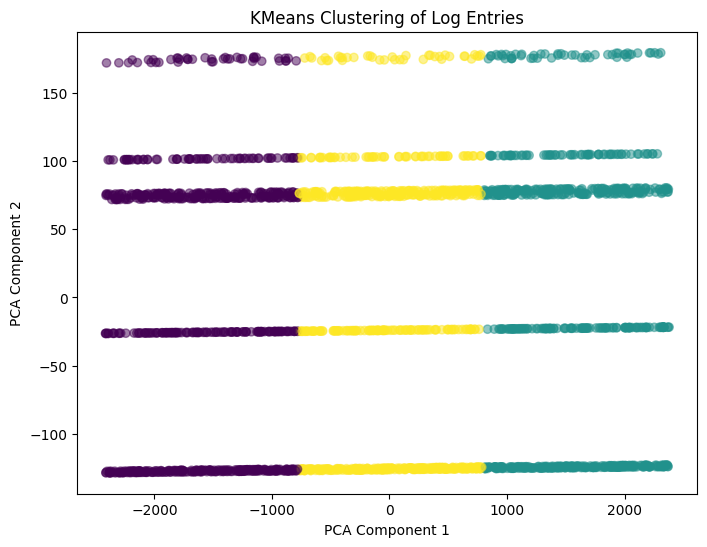

In [12]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Train KMeans
kmeans = KMeans(n_clusters=3, random_state=42)    #Simplest K Means assuming there are 3 clusters (Internal Safe, External Safe, External Malicious)
df["cluster"] = kmeans.fit_predict(features)

# Dimensionality reduction for visualization
pca = PCA(n_components=2)
reduced = pca.fit_transform(features)

plt.figure(figsize=(8,6))
plt.scatter(reduced[:,0], reduced[:,1], c=df["cluster"], cmap="viridis", alpha=0.5)
plt.title("KMeans Clustering of Log Entries")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

In [13]:
# Lets do an autoencoder approach.
# Mostly internal IPs hitting external IPs is safe and normal transaction. We can also set limit on transfer size as 2000B etc
# So we'll use that assumed normal transactions to train autoencoders
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Normalize data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(features)    # Fit a scaler from entire data and just transform entire data

In [14]:
df.endpoint.value_counts()

,count
endpoint,
/admin,144
/services,144
/backup,143
/hidden,143
/about,141
/users/export,140
/users/login,138
/db,137
/staff,133


In [15]:
# Train only on "normal-like" data (example: internal + public endpoints)
#normal_data = df[(df["is_internal"] == True)]
# Define endpoint categories
endpoints_public = ["/home", "/about", "/contact", "/products", "/services", "/users/login", "/users/register"]

endpoints_sensitive = ["/admin", "/staff", "/internal", "/config", "/db", "/backup", "/hidden", "/users/export"]

size_limit = 2000
normal_data = df[(df["is_internal"] == True) & (df["endpoint"].isin(endpoints_public)) & (df["size"] < size_limit)]

X_train = scaler.transform(normal_data[features.columns])   #Norma data as extracted will be only transformed from this scaler fit on entire data

In [16]:
# Define Autoencoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
autoencoder = Sequential()

# Encoder part (compress data)
autoencoder.add(Dense(16, activation='relu', input_shape=(X_train.shape[1],)))
autoencoder.add(Dense(8, activation='relu'))
autoencoder.add(Dense(4, activation='relu'))  # bottleneck layer

# Decoder part (reconstruct data)
autoencoder.add(Dense(8, activation='relu'))
autoencoder.add(Dense(16, activation='relu'))
autoencoder.add(Dense(X_train.shape[1], activation='sigmoid'))  # output = same dimension as input

# Compile
autoencoder.compile(optimizer='adam', loss='mse')


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
# Train Autoencoder
# ----------------------------
history = autoencoder.fit(
    X_train, X_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    shuffle=True,
    verbose=1)

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.1481 - val_loss: 0.1491
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1465 - val_loss: 0.1463
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1415 - val_loss: 0.1424
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1388 - val_loss: 0.1373
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1325 - val_loss: 0.1305
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1240 - val_loss: 0.1219
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1179 - val_loss: 0.1117
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1088 - val_loss: 0.1010
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0982 - val_loss: 0.0910
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0849 - val_loss: 0.0831
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0807 - val_loss: 0.0775
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0761 - val_loss: 0.0738
E

In [18]:
# Evaluate Reconstruction Error
import numpy as np
reconstructions = autoencoder.predict(X_scaled)  # Now make predictions on entire data
mse = np.mean(np.power(X_scaled - reconstructions, 2), axis=1)

# Threshold: mean + 2*std   ---  Subject to changes
threshold = np.mean(mse) + 2*np.std(mse)
print(threshold)
df["reconstruction_error"] = mse
df["is_anomaly"] = df["reconstruction_error"] > threshold    # If reconstruction error is more, we may guess that they are anomalous.

print(df[["ip", "endpoint", "status", "is_anomaly"]].head(30))

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
0.3470035346588951
               ip         endpoint  status  is_anomaly
0      172.16.0.2           /admin     429       False
1     192.168.1.5           /staff     200       False
2     45.133.1.56        /internal     403       False
3    192.168.0.12        /internal     302       False
4    192.168.0.12            /home     200       False
5     45.133.1.56          /config     500        True
6     203.0.113.9           /staff     503        True
7       77.88.8.8        /services     200       False
8     45.133.1.56              /db     401       False
9   192.168.100.3              /db     302       False
10       10.1.1.5              /db     401       False
11        8.8.8.8          /backup     429        True
12    203.0.113.9            /home     403       False
13        8.8.8.8        /services     401       False
14        8.8.8.8  /users/register     404       False
15    10.10.10.10              /db     302       False
16     

In [19]:
# If we have to deploy it, save all preprocessing steps, (without missing any) into pickle. The model however has to be saved in keras h5 format only.

import pickle

# Save encoders and scaler
with open("le_method.pkl", "wb") as f:
    pickle.dump(le_method, f)

with open("le_endpoint.pkl", "wb") as f:
    pickle.dump(le_endpoint, f)

with open("le_agent.pkl", "wb") as f:
    pickle.dump(le_agent, f)

with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

# Save Keras autoencoder
autoencoder.save("autoencoder.h5")

# Requirements.txt
!pip freeze > requirements.txt

In [20]:
from google.colab import files

files.download("le_method.pkl")
files.download("le_endpoint.pkl")
files.download("le_agent.pkl")
files.download("scaler.pkl")
files.download("autoencoder.h5")
files.download("requirements.txt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##### Lets do a semi supervised approach, where we go by heuristics first for predictable traffic and use it train the model. Then we get into labeling what wasn't obvious after training.

In [21]:
# Heuristic Labelling

# Label -1 = unlabeled
df["label"] = -1

# Normal heuristic: internal + public + small size
size_limit = 2000
df.loc[(df["is_internal"]) &
       (df["endpoint"].isin(endpoints_public)) &
       (df["size"] < size_limit), "label"] = 0

# Suspicious heuristic: external + sensitive OR suspicious agent
suspicious_agents = ["sqlmap", "nmap", "python-requests"]
df.loc[(~df["is_internal"]) &
       (df["endpoint"].isin(endpoints_sensitive)), "label"] = 1
df.loc[df["agent"].str.contains("|".join(suspicious_agents)), "label"] = 1

print(df["label"].value_counts())  # how many 0/1/-1

label
-1    962
 1    880
 0    158
Name: count, dtype: int64


In [22]:
df.status.value_counts()

,count
status,
200,358
302,339
201,318
429,188
404,182
401,178
400,156
403,149
502,54


In [23]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Divide data into training and testing data

X_train = df.loc[df["label"] != -1].copy()
y_train = df.loc[df["label"] != -1, "label"].copy()

X_unlabeled = df.loc[df["label"] == -1].copy()

# Fit preprocessors only on labelled data (normal + suspicious seed set)

# Encode categorical variables
le_method = LabelEncoder()
le_endpoint = LabelEncoder()
le_agent = LabelEncoder()
le_status = LabelEncoder()

X_train["method_enc"] = le_method.fit_transform(X_train["method"])
X_train["endpoint_enc"] = le_endpoint.fit_transform(X_train["endpoint"])
X_train["agent_enc"] = le_agent.fit_transform(X_train["agent"])
X_train["status_enc"] = le_status.fit_transform(X_train["status"].astype(str))   # Treating status as categorical variable

X_unlabeled["method_enc"] = le_method.transform(X_unlabeled["method"])
X_unlabeled["endpoint_enc"] = le_endpoint.transform(X_unlabeled["endpoint"])
X_unlabeled["agent_enc"] = le_agent.transform(X_unlabeled["agent"])
X_unlabeled["status_enc"] = le_status.transform(X_unlabeled["status"].astype(str))

# Scale numerics
scaler = MinMaxScaler()
X_train["size_scal"] = scaler.fit_transform(X_train[["size"]])
X_unlabeled["size_scal"] = scaler.transform(X_unlabeled[["size"]])


In [24]:
# Final feature columns for NN
feature_cols = ["method_enc", "endpoint_enc", "agent_enc", "status_enc", "size_scal", "is_internal"]

X_train_ready = X_train[feature_cols].astype("float32").values
y_train_ready = y_train.astype("float32").values

X_unlabeled_ready = X_unlabeled[feature_cols].astype("float32").values


In [25]:
X_train_ready[0]

array([1.       , 8.       , 7.       , 5.       , 0.7820459, 0.       ],
      dtype=float32)

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# NN classifier
clf = Sequential()
clf.add(Dense(32, activation="relu", input_shape=(X_train_ready.shape[1],)))
clf.add(Dense(16, activation="relu"))
clf.add(Dense(1, activation="sigmoid"))  # binary classification

clf.compile(optimizer=Adam(learning_rate=0.001),
            loss="binary_crossentropy",
            metrics=["accuracy"])

# Train model
history = clf.fit(
    X_train_ready, y_train_ready,
    epochs=15,
    batch_size=32,
    validation_split=0.2,
    verbose=1)


Epoch 1/15


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.3317 - loss: 1.1262 - val_accuracy: 0.8413 - val_loss: 0.3518
Epoch 2/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8381 - loss: 0.3449 - val_accuracy: 0.8462 - val_loss: 0.2734
Epoch 3/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8416 - loss: 0.2817 - val_accuracy: 0.9087 - val_loss: 0.2168
Epoch 4/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8973 - loss: 0.2132 - val_accuracy: 0.9231 - val_loss: 0.1878
Epoch 5/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9102 - loss: 0.1923 - val_accuracy: 0.9375 - val_loss: 0.1675
Epoch 6/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9226 - loss: 0.1717 - val_accuracy: 0.9423 - val_loss: 0.1522
Epoch 7/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9383 - loss: 0.1481 - val_accuracy: 0.9519 - val_loss: 0.1375
Epoch 8/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9384 - loss: 0.1428 - val_accuracy: 0.9519 - val_loss: 0.1255
Ep

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

         0.0       1.00      0.85      0.92       158
         1.0       0.97      1.00      0.99       880

    accuracy                           0.98      1038
   macro avg       0.99      0.92      0.95      1038
weighted avg       0.98      0.98      0.98      1038



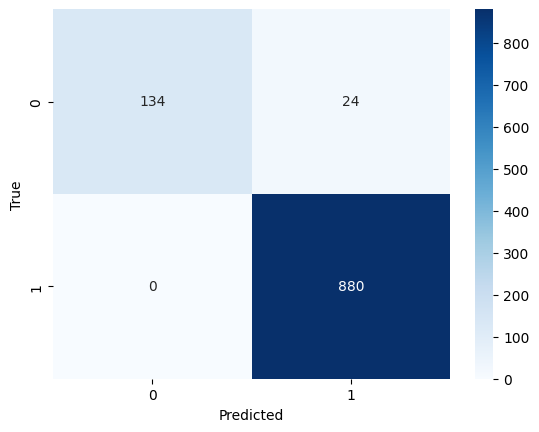

In [27]:
# Evaluating on training data: Since we don’t have ground truth, we only check how well it fits our heuristics.
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_train = (clf.predict(X_train_ready).flatten() > 0.5).astype(int)

print(classification_report(y_train_ready, y_pred_train))

cm = confusion_matrix(y_train_ready, y_pred_train)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [28]:
# Predict probabilities for unlabeled
unlabeled_probs = clf.predict(X_unlabeled_ready).flatten()

# Add predictions to dataframe
X_unlabeled["pred_prob"] = unlabeled_probs
X_unlabeled["pred_label"] = (unlabeled_probs > 0.5).astype(int)

print(X_unlabeled[["ip", "endpoint", "status", "pred_prob", "pred_label"]].head(10))


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
               ip         endpoint  status  pred_prob  pred_label
0      172.16.0.2           /admin     429   0.999451           1
1     192.168.1.5           /staff     200   0.373475           0
4    192.168.0.12            /home     200   0.570387           1
9   192.168.100.3              /db     302   0.777502           1
12    203.0.113.9            /home     403   0.985774           1
14        8.8.8.8  /users/register     404   0.970220           1
15    10.10.10.10              /db     302   0.259490           0
17     172.16.0.2          /backup     401   0.964080           1
18       10.0.0.1            /home     302   0.300542           0
20   192.168.0.11          /config     404   0.996379           1


In [29]:
# You could repeat the training loop using this process
# High-confidence pseudo-labels
threshold_low, threshold_high = 0.1, 0.9
pseudo_labels = np.full_like(unlabeled_probs, -1, dtype=int)
pseudo_labels[unlabeled_probs < threshold_low] = 0
pseudo_labels[unlabeled_probs > threshold_high] = 1

# Assign pseudo-labels
X_unlabeled["pseudo_label"] = pseudo_labels
print(X_unlabeled["pseudo_label"].value_counts())

pseudo_label
-1    539
 1    344
 0     79
Name: count, dtype: int64
